# ASR Assignment 2021-22

This notebook has been provided as a template to get you started on the assignment.  Feel free to use it for your development, or do your development directly in Python.

You can find a full description of the assignment [here](http://www.inf.ed.ac.uk/teaching/courses/asr/2021-22/coursework.pdf).

You are provided with two Python modules `observation_model.py` and `wer.py`.  The first was described in [Lab 3](https://github.com/ZhaoZeyu1995/asr_labs/blob/master/asr_lab3_4.ipynb).  The second can be used to compute the number of substitution, deletion and insertion errors between ASR output and a reference text.

It can be used as follows:

```python
import wer

my_refence = 'A B C'
my_output = 'A C C D'

wer.compute_alignment_errors(my_reference, my_output)
```

This produces a tuple $(s,d,i)$ giving counts of substitution,
deletion and insertion errors respectively - in this example (1, 0, 1).  The function accepts either two strings, as in the example above, or two lists.  Matching is case sensitive.

## Template code

Assuming that you have already made a function to generate an WFST, `create_wfst()` and a decoder class, `MyViterbiDecoder`, you can perform recognition on all the audio files as follows:


### Import Library

In [32]:
import glob
import os
import wer
import observation_model
import openfst_python as fst
import math
import numpy as np
import time
import pandas as pd
import heapq

In [2]:
# configurations
class CFG:
    DEBUG = True
    if DEBUG:
        sample_num = 2
    else:
        sample_num = None
    
    audio_path = '/group/teaching/asr/labs/recordings/*.wav'

### Generate State Table, Phone Table, Word Table from the Lexicon

In [3]:
def parse_lexicon(lex_file):
    """
    Parse the lexicon file and return it in dictionary form.
    
    Args:
        lex_file (str): filename of lexicon file with structure '<word> <phone1> <phone2>...'
                        eg. peppers p eh p er z

    Returns:
        lex (dict): dictionary mapping words to list of phones
    """
    
    lex = {}  # create a dictionary for the lexicon entries (this could be a problem with larger lexica)
    with open(lex_file, 'r') as f:
        for line in f:
            line = line.split()  # split at each space
            lex[line[0]] = line[1:]  # first field the word, the rest is the phones
    return lex




def generate_symbol_tables(lexicon, n=3):
    '''
    Return word, phone and state symbol tables based on the supplied lexicon
    
    Args:
        lexicon (dict): lexicon to use, created from the parse_lexicon() function
        n (int): number of states for each phone HMM
        
    Returns:
        word_table (fst.SymbolTable): table of words
        phone_table (fst.SymbolTable): table of phones
        state_table (fst.SymbolTable): table of HMM phone-state IDs
    '''
    state_table = fst.SymbolTable()
    phone_table = fst.SymbolTable()
    word_table = fst.SymbolTable()
    
    # add empty <eps> symbol to all tables
    state_table.add_symbol('<eps>')
    phone_table.add_symbol('<eps>')
    word_table.add_symbol('<eps>')
    
    for word, phones  in lexicon.items():
        
        word_table.add_symbol(word)
        
        for p in phones: # for each phone
            
            phone_table.add_symbol(p)
            for i in range(1,n+1): # for each state 1 to n
                state_table.add_symbol('{}_{}'.format(p, i))

    return word_table, phone_table, state_table




lex = parse_lexicon('lexicon.txt')
word_table, phone_table, state_table = generate_symbol_tables(lex)

### Baseline wfst (my lab1 solution) (+probability hyperparameter option)

In [4]:
class BaselineWfst:
    
    def __init__(self, n=3, lex=lex, self_loop_prob=None, final_prob_dict=None, uni_prob_dict=None):
        """
        Generate a HMM to recognise any single word sequence for words in the lexicon

        Args:
            n (int): states per phone HMM
            lex: lexicon
            self_loop_prob: hyperparameter
            final_prob_dict: hyperparameter dictionary
            uni_prob_dict: hyperparameter dictionary

        Returns:
            class storing the constructed WFST

        """
        
        self.n = n
        self.lex = lex
        self.final_prob_dict = final_prob_dict
        self.self_loop_prob = self_loop_prob
        self.uni_prob_dict = uni_prob_dict
        self.f = self.generate_wfst()
    
        
    
    def generate_weighted_phone_wfst(self, f, start_state, phone, n, olabel):
        """
        Generate a weighted WFST representing an n-state left-to-right phone HMM.
        Internal function for creating word wfst

        Args:
            f (fst.Fst()): an FST object, assumed to exist already
            start_state (int): the index of the first state, assumed to exist already
            phone (str): the phone label 
            n (int): number of states of the HMM excluding start and end

        Returns:
            the final state of the FST
        """
    

        current_state = start_state

        for i in range(1, n+1):
            if i == n:
                out = olabel
            else:
                out = 0

            in_label = state_table.find('{}_{}'.format(phone, i))

            prev_state = current_state
            current_state = f.add_state()
            if self.self_loop_prob == None:
                f.add_arc(prev_state, fst.Arc(in_label, 0, None, prev_state))
                f.add_arc(prev_state, fst.Arc(in_label, out, None, current_state))
            else:
                f.add_arc(prev_state, fst.Arc(in_label, 0, -math.log(self.self_loop_prob), prev_state))
                f.add_arc(prev_state, fst.Arc(in_label, out, -math.log(1-self.self_loop_prob), current_state))
        
        return current_state
    
    
    def generate_wfst(self):
        """
        """
        
        f = fst.Fst()

        # create a single start state
        start_state = f.add_state()
        f.set_start(start_state)

        for word, phones in self.lex.items():
            current_state = f.add_state()
            if self.uni_prob_dict == None:
                f.add_arc(start_state, fst.Arc(0, 0, None, current_state))
            else:
                f.add_arc(start_state, fst.Arc(0, 0, -math.log(self.uni_prob_dict[word]), current_state))
            for idx,phone in enumerate(phones):
                if idx == len(phones)-1:
                    olabel = word_table.find(word)
                    current_state = self.generate_weighted_phone_wfst(f, current_state, phone, self.n, olabel)
                else:
                    current_state = self.generate_weighted_phone_wfst(f, current_state, phone, self.n, 0)
            # note: new current_state is now set to the final state of the previous phone WFST
            if self.final_prob_dict == None:
                f.set_final(current_state)
            else:
                f.set_final(current_state, -math.log(self.final_prob_dict[word]))
            f.add_arc(current_state, fst.Arc(0, 0, 0, start_state))
        
        f.set_input_symbols(state_table)
        f.set_output_symbols(word_table)
        
        return f

    
    def plot(self):
        """
        """
    
        # We need special code to display the higher-resolution WFSTs inside Jupyter notebook
        from subprocess import check_call
        from IPython.display import Image    
        self.f.draw('tmp.dot', portrait=True)
        check_call(['dot','-Tpng','-Gdpi=200','tmp.dot','-o','tmp.png'])
        return Image(filename='tmp.png')
    

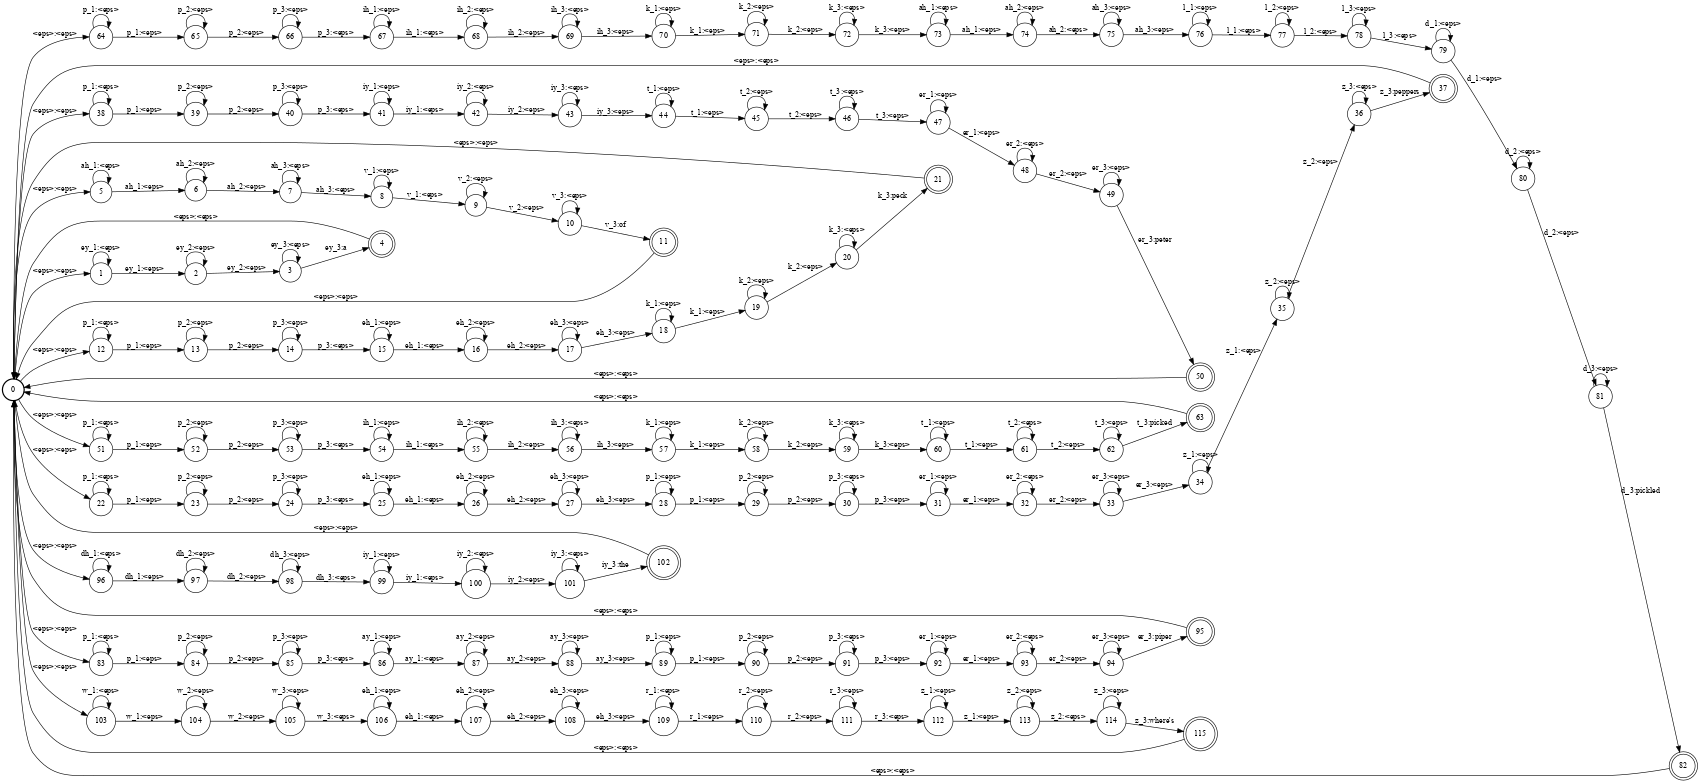

In [5]:
BaselineWfst().plot()

### Baseline Viterbi Decoder (lab3_4 solution)

In [6]:
class BaselineViterbiDecoder:
    
    NLL_ZERO = 1e10  # define a constant representing -log(0).  This is really infinite, but approximate
                     # it here with a very large number
    
    def __init__(self, f = None, audio_file_name = None):
        """Set up the decoder class with an audio file and WFST f
        """
        self.om = observation_model.ObservationModel()
        self.f = f
        self.audio_file_name = audio_file_name
        
        
    def initialise_decoding(self):
        """set up the values for V_j(0) (as negative log-likelihoods)
        
        """
        # dynamic loading
        if self.audio_file_name:
            self.om.load_audio(self.audio_file_name)
        else:
            self.om.load_dummy_audio()
    
    
        self.forward_cnt = 0

        
        self.V = []   # stores likelihood along best path reaching state j
        self.B = []   # stores identity of best previous state reaching state j
        self.W = []   # stores output labels sequence along arc reaching j - this removes need for 
                      # extra code to read the output sequence along the best path
        
        for t in range(self.om.observation_length()+1):
            self.V.append([self.NLL_ZERO]*self.f.num_states())
            self.B.append([-1]*self.f.num_states())
            self.W.append([[] for i in range(self.f.num_states())])  #  multiplying the empty list doesn't make multiple
        
        # The above code means that self.V[t][j] for t = 0, ... T gives the Viterbi cost
        # of state j, time t (in negative log-likelihood form)
        # Initialising the costs to NLL_ZERO effectively means zero probability    
        
        # give the WFST start state a probability of 1.0   (NLL = 0.0)
        self.V[0][self.f.start()] = 0.0
        
        # some WFSTs might have arcs with epsilon on the input (you might have already created 
        # examples of these in earlier labs) these correspond to non-emitting states, 
        # which means that we need to process them without stepping forward in time.  
        # Don't worry too much about this!  
        self.traverse_epsilon_arcs(0)        
        
    def traverse_epsilon_arcs(self, t):
        """Traverse arcs with <eps> on the input at time t
        
        These correspond to transitions that don't emit an observation
        
        We've implemented this function for you as it's slightly trickier than
        the normal case.  You might like to look at it to see what's going on, but
        don't worry if you can't fully follow it.
        
        """
        
        states_to_traverse = list(self.f.states()) # traverse all states
        while states_to_traverse:
            
            # Set i to the ID of the current state, the first 
            # item in the list (and remove it from the list)
            i = states_to_traverse.pop(0)   
        
            # don't bother traversing states which have zero probability
            if self.V[t][i] == self.NLL_ZERO:
                    continue
        
            for arc in self.f.arcs(i):
                
                if arc.ilabel == 0:     # if <eps> transition
                  
                    j = arc.nextstate   # ID of next state  
                
                    if self.V[t][j] > self.V[t][i] + float(arc.weight):
                        
                        # this means we've found a lower-cost path to
                        # state j at time t.  We might need to add it
                        # back to the processing queue.
                        self.V[t][j] = self.V[t][i] + float(arc.weight)
                        
                        # save backtrace information.  In the case of an epsilon transition, 
                        # we save the identity of the best state at t-1.  This means we may not
                        # be able to fully recover the best path, but to do otherwise would
                        # require a more complicated way of storing backtrace information
                        self.B[t][j] = self.B[t][i] 
                        
                        # and save the output labels encountered - this is a list, because
                        # there could be multiple output labels (in the case of <eps> arcs)
                        if arc.olabel != 0:
                            self.W[t][j] = self.W[t][i] + [arc.olabel]
                        else:
                            self.W[t][j] = self.W[t][i]
                        
                        if j not in states_to_traverse:
                            states_to_traverse.append(j)

    
    def forward_step(self, t):
            
        for i in self.f.states():

            if not self.V[t-1][i] == self.NLL_ZERO:   # no point in propagating states with zero probability
                
                for arc in self.f.arcs(i):
                    
                    if arc.ilabel != 0: # <eps> transitions don't emit an observation
                        j = arc.nextstate
                        tp = float(arc.weight)  # transition prob
                        ep = -self.om.log_observation_probability(self.f.input_symbols().find(arc.ilabel), t)  # emission negative log prob
                        prob = tp + ep + self.V[t-1][i] # they're logs
                        
                        self.forward_cnt += 1
                        
                        if prob < self.V[t][j]:
                            self.V[t][j] = prob
                            self.B[t][j] = i
                            
                            # store the output labels encountered too
                            if arc.olabel !=0:
                                self.W[t][j] = [arc.olabel]
                            else:
                                self.W[t][j] = []
                            
    
    def finalise_decoding(self):
        """ this incorporates the probability of terminating at each state
        """
        
        for state in self.f.states():
            final_weight = float(self.f.final(state))
            if self.V[-1][state] != self.NLL_ZERO:
                if final_weight == math.inf:
                    self.V[-1][state] = self.NLL_ZERO  # effectively says that we can't end in this state
                else:
                    self.V[-1][state] += final_weight
                    
        # get a list of all states where there was a path ending with non-zero probability
        finished = [x for x in self.V[-1] if x < self.NLL_ZERO]
        if not finished:  # if empty
            print("No path got to the end of the observations.")
        
        
    def decode(self):
        self.initialise_decoding()
        t = 1
        while t <= self.om.observation_length():
            self.forward_step(t)
            self.traverse_epsilon_arcs(t)
            t += 1
        self.finalise_decoding()
    
    def backtrace(self):
        
        best_final_state = self.V[-1].index(min(self.V[-1])) # argmin
        best_state_sequence = [best_final_state]
        best_out_sequence = []
        
        t = self.om.observation_length()   # ie T
        j = best_final_state
        
        while t >= 0:
            i = self.B[t][j]
            best_state_sequence.append(i)
            best_out_sequence = self.W[t][j] + best_out_sequence  # computer scientists might like
                                                                                # to make this more efficient!

            # continue the backtrace at state i, time t-1
            j = i  
            t-=1
            
        best_state_sequence.reverse()
        
        # convert the best output sequence from FST integer labels into strings
        best_out_sequence = ' '.join([self.f.output_symbols().find(label) for label in best_out_sequence])
        
        return (best_state_sequence, best_out_sequence)


### ASR class

In [7]:
def read_transcription(wav_file):
    """
    Get the transcription corresponding to wav_file.
    """
    
    transcription_file = os.path.splitext(wav_file)[0] + '.txt'
    
    with open(transcription_file, 'r') as f:
        transcription = f.readline().strip()
    
    return transcription


    
class ASR:
    
    def __init__(self, f, decoder, audio_path, sample_num = None, verbose_all = True, verbose_result = True):
        
        """
        Generate a ASR class with a created f from a wfst and a decoder for all existing audio files that match with the audio path.

        Args:
            f (fst.Fst()): an FST object, assumed to exist already
            decoder (class): the index of the first state, assumed to exist already
            audio_path (str): path of the file or folder
            sample_num (int): number of the samples that will be executed from the start of the list at the audio path.
            verbose_all (bool): print result for all audio files
            verbose_result (bool): print the final averaged result

        """
        self.f = f
        self.decoder = decoder
        self.audio_path = audio_path
        self.sample_num = sample_num
        self.verbose_all = verbose_all
        self.verbose_result = verbose_result
        
        self.run()
    
    
    def run(self):
        """
        """
        
        
        records = []
        
        self.decoder.f = self.f
        
        # run for each .wav file
        for idx,wav_file in enumerate(glob.glob(self.audio_path)):    # replace path if using your own
                                                                       # audio files
            # end
            if self.sample_num and idx >= self.sample_num: break
                
            # set decoder argument
            self.decoder.audio_file_name = wav_file

            # measure decoding time
            start_time = time.time()
            self.decoder.decode()
            decode_time = time.time() - start_time
            
            # measure backtracing time
            start_time = time.time()
            (state_path, words) = self.decoder.backtrace()
            backtrace_time = time.time() - start_time
            
            # measure forward function counts in the decoding process
            forward_cnt = self.decoder.forward_cnt

            
            # measure WER accuracy
            transcription = read_transcription(wav_file)
            (sub_cnt, del_cnt, ins_cnt) = wer.compute_alignment_errors(transcription, words)
            word_cnt = len(transcription.split())
            accuracy = sum([sub_cnt, del_cnt, ins_cnt])/word_cnt
            
            
            # print results for each .wav file
            if self.verbose_all:
                print(wav_file)
                print('Transcription: ' + transcription)
                print('Prediction: ' + words)
                print('Substiution: {}, Deletion: {}, Insertion: {}, Number of words: {}, Accuracy: {:.3f}'
                      .format(sub_cnt, del_cnt, ins_cnt, word_cnt, accuracy))
                print('Forward: {}'.format(forward_cnt))
                print()
            
            
            # save the measurements
            records.append([sub_cnt, del_cnt, ins_cnt, word_cnt, accuracy, decode_time, backtrace_time, forward_cnt])
        
        
        
        # average measurements
        self.sub_cnt, self.del_cnt, self.ins_cnt, self.word_cnt, self.accuracy, self.decode_time, self.backtrace_time, self.forward_cnt = np.average(records, axis=0)
        
        
        # f related measurements
        num_arcs = 0
        for state in self.f.states():
            num_arcs += self.f.num_arcs(state)
        self.num_arcs = num_arcs
        self.num_states = self.f.num_states()
        
        
        # print results
        if self.verbose_result:
            print("====================Result from {} samples==================".format(idx))
            self.print_all()
        
        
        
        
    def print_accuracy(self):
        """
        """
        print('-- Accuracy Info  *All Average Values* '.ljust(100, '-')) 
        print('| Substiution: {:.3f}, Deletion: {:.3f}, Insertion: {:.3f}, Number of words: {:.3f}, Accuracy: {:.3f}'
              .format(self.sub_cnt, self.del_cnt, self.ins_cnt, self.word_cnt, self.accuracy)
              .ljust(99,' ')+'|')
        print(''.ljust(100, '-'))
        
        
    def print_speed(self):
        """
        """
        print('-- Speed Info  *All Average Values* '.ljust(100, '-'))
        print('| Decoding time: {:.3f}s, Backtracing time: {:.3f}s, Number of forward computations: {:.3f}'
              .format(self.decode_time, self.backtrace_time, self.forward_cnt)
              .ljust(99,' ')+'|')
        print(''.ljust(100, '-'))
    
    
    def print_memory(self):
        """
        """
        print('-- Memory Info '.ljust(100, '-'))
        print('| Number of states: {}, Number of arcs: {}'
              .format(self.num_states, self.num_arcs)
              .ljust(99,' ')+'|')
        print(''.ljust(100, '-'))

        
    def print_all(self):
        """
        """
        self.print_accuracy()
        self.print_speed()
        self.print_memory()
        print()
        

## Task 1 -Baseline-

In [8]:
# create WFST and decoder
f = BaselineWfst().f
decoder = BaselineViterbiDecoder()

# create ASR
asr = ASR(f, decoder, CFG.audio_path, CFG.sample_num, verbose_all = True, verbose_result = True)

# save result in a dataframe
result_df_1 = pd.DataFrame(columns=["self-prob", "accuracy","num_arcs",
                                      "num_states","decode_time", "backtrace_time", "forward_cnt"])
tmp = pd.Series([None, asr.accuracy, asr.num_arcs, asr.num_states, 
                     asr.decode_time, asr.backtrace_time, asr.forward_cnt], index=result_df_1.columns, name=0)
result_df_1 = result_df_1.append(tmp)
if CFG.DEBUG == False:
    result_df_1.to_csv("task_1_baseline_df.csv",index=False)
result_df_1

/group/teaching/asr/labs/recordings/0000.wav
Transcription: of of a peter the piper the pickled
Prediction: the a of a of of peter the a of picked a peppers the the picked the
Substiution: 3, Deletion: 0, Insertion: 9, Number of words: 8, Accuracy: 1.500
Forward: 113478

/group/teaching/asr/labs/recordings/0001.wav
Transcription: piper peck peppers peter peter picked pickled peck peter piper
Prediction: the a the of a peppers peter peter picked picked pickled peck the peter piper the
Substiution: 2, Deletion: 0, Insertion: 6, Number of words: 10, Accuracy: 0.800
Forward: 214908

====================Result from 2 samples==================
-- Accuracy Info  *All Average Values* -------------------------------------------------------------
| Substiution: 2.500, Deletion: 0.000, Insertion: 7.500, Number of words: 9.000, Accuracy: 1.150   |
----------------------------------------------------------------------------------------------------
-- Speed Info  *All Average Values* ---------------

,self-prob,accuracy,num_arcs,num_states,decode_time,backtrace_time,forward_cnt
0,NaN,1.15,230.0,116.0,8.122526,0.004325,164193.0


## Task 2 -WFST tests-

1~3: Change hyperparameters for BaselineWfst class  
4: Create a new SilenceWfst class

### 1. Self-loop probability

In [9]:
result_df_2_1 = pd.DataFrame(columns=["self-prob", "accuracy","num_arcs",
                                      "num_states","decode_time", "backtrace_time", "forward_cnt"])
for i in range(1, 10):
    prob = i * 0.1
    print("Self loop probability={}".format(prob))
    
    
    # create WFST and decoder
    f = BaselineWfst(self_loop_prob=prob).f
    decoder = BaselineViterbiDecoder()
    
    # create ASR
    asr = ASR(f, decoder, CFG.audio_path, CFG.sample_num, verbose_all = True, verbose_result = True)
    
    # save result in a dataframe
    tmp = pd.Series([prob, asr.accuracy, asr.num_arcs, asr.num_states, 
                     asr.decode_time, asr.backtrace_time, asr.forward_cnt], index=result_df_2_1.columns, name=i)
    result_df_2_1 = result_df_2_1.append(tmp)
    
if CFG.DEBUG == False:
    result_df_2_1.to_csv("task_2_self_loop_df.csv",index=False)
    
result_df_2_1

Self loop probability=0.1
/group/teaching/asr/labs/recordings/0000.wav
Transcription: of of a peter the piper the pickled
Prediction: peck the the a of a of the of peter the peck a a of picked a a piper pickled the the pickled picked the the a
Substiution: 1, Deletion: 0, Insertion: 19, Number of words: 8, Accuracy: 2.500
Forward: 113478

/group/teaching/asr/labs/recordings/0001.wav
Transcription: piper peck peppers peter peter picked pickled peck peter piper
Prediction: peck the the the the the the the the the the a peter of a a peppers a peter peter picked picked pickled peck the the peter picked piper picked the picked the
Substiution: 0, Deletion: 1, Insertion: 24, Number of words: 10, Accuracy: 2.500
Forward: 214908

====================Result from 2 samples==================
-- Accuracy Info  *All Average Values* -------------------------------------------------------------
| Substiution: 0.500, Deletion: 0.500, Insertion: 21.500, Number of words: 9.000, Accuracy: 2.500  |
------

/group/teaching/asr/labs/recordings/0001.wav
Transcription: piper peck peppers peter peter picked pickled peck peter piper
Prediction: the a the of a peppers peter peter picked picked pickled peck the peter piper the
Substiution: 2, Deletion: 0, Insertion: 6, Number of words: 10, Accuracy: 0.800
Forward: 214908

====================Result from 2 samples==================
-- Accuracy Info  *All Average Values* -------------------------------------------------------------
| Substiution: 2.500, Deletion: 0.000, Insertion: 7.000, Number of words: 9.000, Accuracy: 1.087   |
----------------------------------------------------------------------------------------------------
-- Speed Info  *All Average Values* ----------------------------------------------------------------
| Decoding time: 8.023s, Backtracing time: 0.001s, Number of forward computations: 164193.000      |
----------------------------------------------------------------------------------------------------
-- Memory Info -----

,self-prob,accuracy,num_arcs,num_states,decode_time,backtrace_time,forward_cnt
1,0.1,2.5000,230.0,116.0,8.100023,0.001507,164193.0
2,0.2,1.5375,230.0,116.0,8.223061,0.002293,164193.0
3,0.3,1.3000,230.0,116.0,8.012791,0.001734,164193.0
4,0.4,1.2000,230.0,116.0,8.037818,0.001688,164193.0
5,0.5,1.1500,230.0,116.0,7.961733,0.005979,164193.0
6,0.6,1.0875,230.0,116.0,8.023207,0.000993,164193.0
7,0.7,1.0875,230.0,116.0,7.873207,0.001162,164193.0
8,0.8,0.9375,230.0,116.0,8.060530,0.000706,164193.0
9,0.9,0.8125,230.0,116.0,7.832327,0.000668,164193.0


### 2. Final probality

In [10]:
print("Final probability of <of>:",BaselineWfst().f.final(11))
print("Final probability of <eps>:",BaselineWfst().f.final(12))

final_word_count = dict()
for word in lex.keys():
    final_word_count[word] = 0

for file in glob.glob(CFG.audio_path):
    transcript = read_transcription(file)
    final_word = transcript.split()[-1]
    final_word_count[final_word] += 1
final_word_dict = dict()
for word in lex.keys():
    final_word_dict[word] = final_word_count[word]/len(glob.glob(CFG.audio_path))
final_word_dict

Final probability of <of>: 0
Final probability of <eps>: Infinity


{'a': 0.0028169014084507044,
 'of': 0.011267605633802818,
 'peck': 0.07605633802816901,
 'peppers': 0.37183098591549296,
 'peter': 0.10140845070422536,
 'picked': 0.28169014084507044,
 'pickled': 0.04507042253521127,
 'piper': 0.09859154929577464,
 'the': 0.005633802816901409,
 "where's": 0.005633802816901409}

In [11]:
# create WFST and decoder
f = BaselineWfst(final_prob_dict=final_word_dict).f
decoder = BaselineViterbiDecoder()

# create ASR
asr = ASR(f, decoder, CFG.audio_path, CFG.sample_num, verbose_all = True, verbose_result = True)

# save result in a dataframe
result_df_2_2 = pd.DataFrame(columns=["self-prob", "accuracy","num_arcs",
                                      "num_states","decode_time", "backtrace_time", "forward_cnt"])
tmp = pd.Series([None, asr.accuracy, asr.num_arcs, asr.num_states, 
                     asr.decode_time, asr.backtrace_time, asr.forward_cnt], index=result_df_2_1.columns, name=0)
result_df_2_2 = result_df_2_2.append(tmp)
if CFG.DEBUG == False:
    result_df_2_2.to_csv("task_2_final_prob_df.csv",index=False)
result_df_2_2

/group/teaching/asr/labs/recordings/0000.wav
Transcription: of of a peter the piper the pickled
Prediction: the a of a of of peter the a of picked a peppers the the picked the
Substiution: 3, Deletion: 0, Insertion: 9, Number of words: 8, Accuracy: 1.500
Forward: 113478

/group/teaching/asr/labs/recordings/0001.wav
Transcription: piper peck peppers peter peter picked pickled peck peter piper
Prediction: the a the of a peppers peter peter picked picked pickled peck the peter piper the
Substiution: 2, Deletion: 0, Insertion: 6, Number of words: 10, Accuracy: 0.800
Forward: 214908

====================Result from 2 samples==================
-- Accuracy Info  *All Average Values* -------------------------------------------------------------
| Substiution: 2.500, Deletion: 0.000, Insertion: 7.500, Number of words: 9.000, Accuracy: 1.150   |
----------------------------------------------------------------------------------------------------
-- Speed Info  *All Average Values* ---------------

,self-prob,accuracy,num_arcs,num_states,decode_time,backtrace_time,forward_cnt
0,NaN,1.15,230.0,116.0,8.084791,0.000915,164193.0


In [12]:
for state in f.states():
    print(state, f.final(state))

0 Infinity
1 Infinity
2 Infinity
3 Infinity
4 5.872118
5 Infinity
6 Infinity
7 Infinity
8 Infinity
9 Infinity
10 Infinity
11 4.48582363
12 Infinity
13 Infinity
14 Infinity
15 Infinity
16 Infinity
17 Infinity
18 Infinity
19 Infinity
20 Infinity
21 2.57628083
22 Infinity
23 Infinity
24 Infinity
25 Infinity
26 Infinity
27 Infinity
28 Infinity
29 Infinity
30 Infinity
31 Infinity
32 Infinity
33 Infinity
34 Infinity
35 Infinity
36 Infinity
37 0.989315867
38 Infinity
39 Infinity
40 Infinity
41 Infinity
42 Infinity
43 Infinity
44 Infinity
45 Infinity
46 Infinity
47 Infinity
48 Infinity
49 Infinity
50 2.28859878
51 Infinity
52 Infinity
53 Infinity
54 Infinity
55 Infinity
56 Infinity
57 Infinity
58 Infinity
59 Infinity
60 Infinity
61 Infinity
62 Infinity
63 1.26694763
64 Infinity
65 Infinity
66 Infinity
67 Infinity
68 Infinity
69 Infinity
70 Infinity
71 Infinity
72 Infinity
73 Infinity
74 Infinity
75 Infinity
76 Infinity
77 Infinity
78 Infinity
79 Infinity
80 Infinity
81 Infinity
82 3.09952903
8

### 3. Unigram word probability

In [13]:
word_count = dict()
for word in lex.keys():
    word_count[word] = 0

word_count_all = 0
for file in glob.glob(CFG.audio_path):
    transcript = read_transcription(file)
    tmp_words = transcript.split()
    word_count_all += len(tmp_words)
    for word in tmp_words:
        word_count[word] += 1

for word in word_count.keys():
    word_count[word] /= word_count_all

# create WFST and decoder
f = BaselineWfst(uni_prob_dict=word_count).f
decoder = BaselineViterbiDecoder()

# create ASR
asr = ASR(f, decoder, CFG.audio_path, CFG.sample_num, verbose_all = True, verbose_result = True)

# save result in a dataframe
result_df_2_3 = pd.DataFrame(columns=["self-prob", "accuracy","num_arcs",
                                      "num_states","decode_time", "backtrace_time", "forward_cnt"])
tmp = pd.Series([None, asr.accuracy, asr.num_arcs, asr.num_states, 
                     asr.decode_time, asr.backtrace_time, asr.forward_cnt], index=result_df_2_3.columns, name=0)
result_df_2_3 = result_df_2_3.append(tmp)
if CFG.DEBUG == False:
    result_df_2_3.to_csv("task_2_uni_prob_df.csv",index=False)
result_df_2_3

/group/teaching/asr/labs/recordings/0000.wav
Transcription: of of a peter the piper the pickled
Prediction: the a of a of peter the a of picked a peppers the the picked the
Substiution: 3, Deletion: 0, Insertion: 8, Number of words: 8, Accuracy: 1.375
Forward: 113478

/group/teaching/asr/labs/recordings/0001.wav
Transcription: piper peck peppers peter peter picked pickled peck peter piper
Prediction: the a the of a peppers peter peter picked picked pickled peck the peter piper the
Substiution: 2, Deletion: 0, Insertion: 6, Number of words: 10, Accuracy: 0.800
Forward: 214908

====================Result from 2 samples==================
-- Accuracy Info  *All Average Values* -------------------------------------------------------------
| Substiution: 2.500, Deletion: 0.000, Insertion: 7.000, Number of words: 9.000, Accuracy: 1.087   |
----------------------------------------------------------------------------------------------------
-- Speed Info  *All Average Values* ------------------

,self-prob,accuracy,num_arcs,num_states,decode_time,backtrace_time,forward_cnt
0,NaN,1.0875,230.0,116.0,8.946247,0.001514,164193.0


### 4. Silence state

In [14]:
state_table.add_symbol("sil_1")
state_table.add_symbol("sil_2")
state_table.add_symbol("sil_3")
state_table.add_symbol("sil_4")
state_table.add_symbol("sil_5")

56

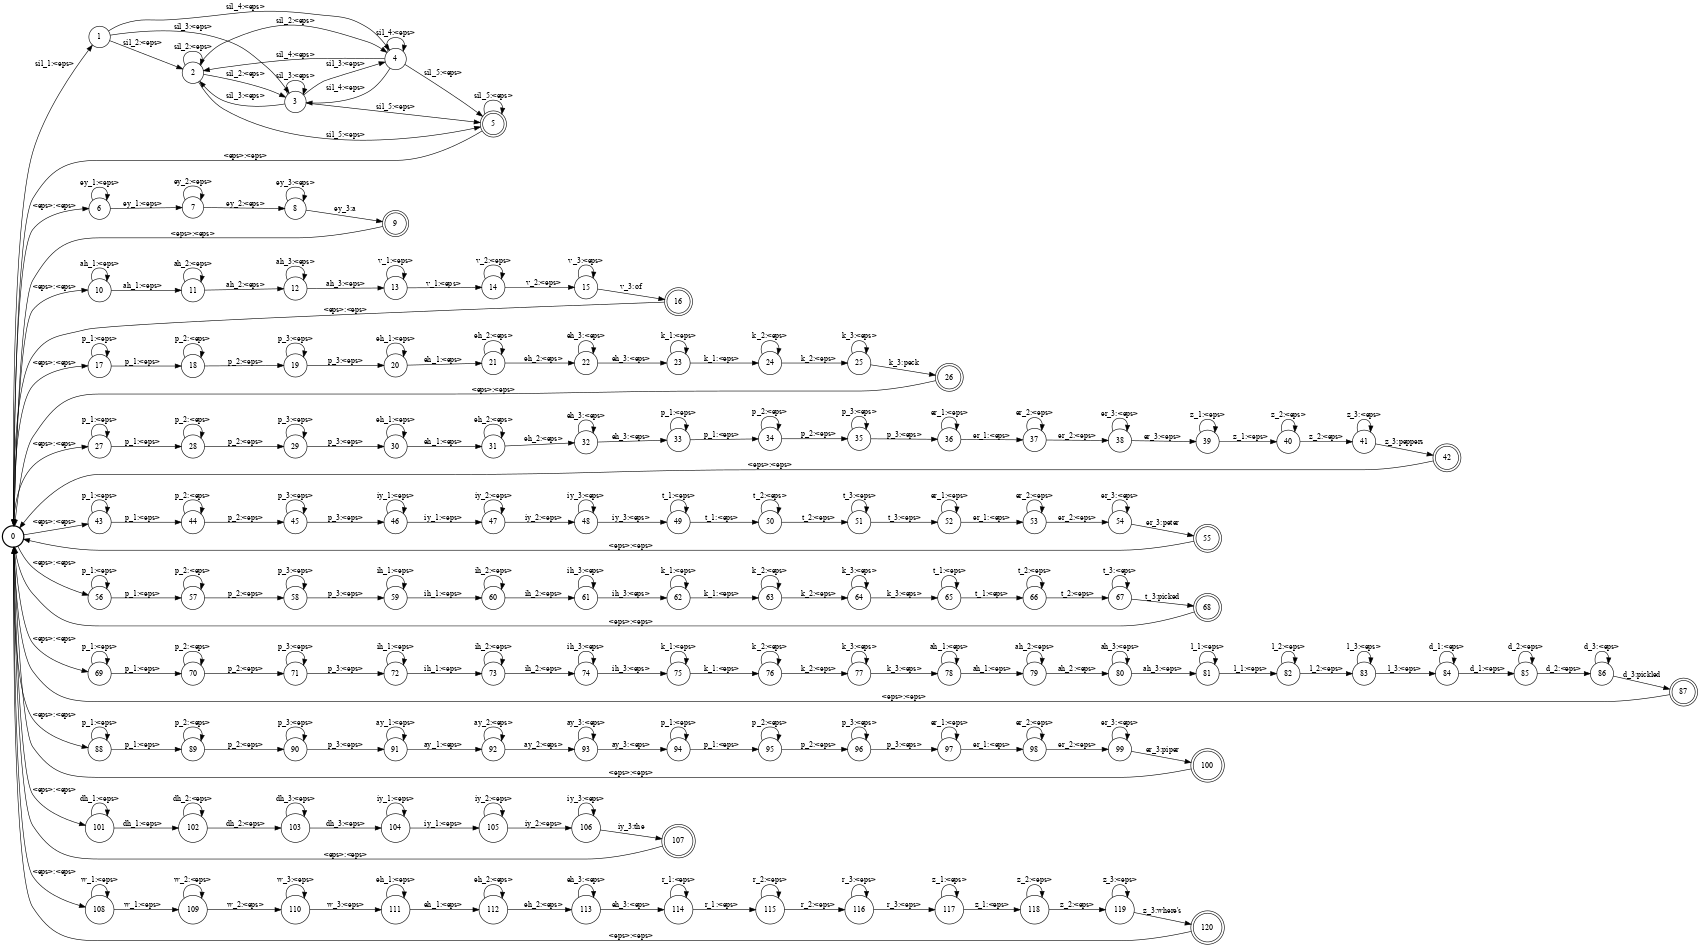

In [15]:
class SilenceWfst:
    
    def __init__(self, n=3, lex=lex, self_loop_prob=None, final_prob_dict=None, uni_prob_dict=None):
        """
        Generate a HMM to recognise any single word sequence for words in the lexicon

        Args:
            n (int): states per phone HMM

        Returns:
            the constructed WFST

        """
        
        self.n = n
        self.lex = lex
        self.final_prob_dict = final_prob_dict
        self.self_loop_prob = self_loop_prob
        self.uni_prob_dict = uni_prob_dict
        self.f = self.generate_wfst()
        
        
    
    def generate_weighted_phone_wfst(self, f, start_state, phone, n, olabel):
        """
        Generate a weighted WFST representing an n-state left-to-right phone HMM.

        Args:
            f (fst.Fst()): an FST object, assumed to exist already
            start_state (int): the index of the first state, assumed to exist already
            phone (str): the phone label 
            n (int): number of states of the HMM excluding start and end

        Returns:
            the final state of the FST
        """
    

        current_state = start_state

        for i in range(1, n+1):
            if i == n:
                out = olabel
            else:
                out = 0

            in_label = state_table.find('{}_{}'.format(phone, i))

            prev_state = current_state
            current_state = f.add_state()
            if self.self_loop_prob == None:
                f.add_arc(prev_state, fst.Arc(in_label, 0, None, prev_state))
                f.add_arc(prev_state, fst.Arc(in_label, out, None, current_state))
            else:
                f.add_arc(prev_state, fst.Arc(in_label, 0, -math.log(self.self_loop_prob), prev_state))
                f.add_arc(prev_state, fst.Arc(in_label, out, -math.log(1-self.self_loop_prob), current_state))
        
        return current_state
    
    
    def generate_wfst(self):
        """
        """
        
        f = fst.Fst()

        # create a single start state
        start_state = f.add_state() # 0
        f.set_start(start_state)
        
        # Silence states
        sil_1_state = f.add_state() # 1
        f.add_arc(start_state, fst.Arc(state_table.find("sil_1"), 0, None, sil_1_state))
        for i in range(2, 6): # 2-5
            f.add_state()
        for i in range(2, 5):
            f.add_arc(sil_1_state, fst.Arc(state_table.find(f"sil_{i}"), 0, None, i))
            for j in range(2, 5):
                f.add_arc(i, fst.Arc(state_table.find(f"sil_{i}"), 0, None, j))
            f.add_arc(i, fst.Arc(state_table.find(f"sil_5"), 0, None, 5))
        f.add_arc(5, fst.Arc(state_table.find("sil_5"), 0, None, 5))
        f.set_final(5)
        f.add_arc(5, fst.Arc(0, 0, None, start_state))  
        for word, phones in self.lex.items():
            current_state = f.add_state()
            if self.uni_prob_dict == None:
                f.add_arc(start_state, fst.Arc(0, 0, None, current_state))
            else:
                f.add_arc(start_state, fst.Arc(0, 0, -math.log(self.uni_prob_dict[word]), current_state))
            for idx,phone in enumerate(phones):
                if idx == len(phones)-1:
                    olabel = word_table.find(word)
                    current_state = self.generate_weighted_phone_wfst(f, current_state, phone, self.n, olabel)
                else:
                    current_state = self.generate_weighted_phone_wfst(f, current_state, phone, self.n, 0)
            # note: new current_state is now set to the final state of the previous phone WFST
            if self.final_prob_dict == None:
                f.set_final(current_state)
            else:
                f.set_final(current_state, -math.log(self.final_prob_dict[word]))
            f.add_arc(current_state, fst.Arc(0, 0, 0, start_state))
        
        f.set_input_symbols(state_table)
        f.set_output_symbols(word_table)
        
        return f

    
    def plot(self):
        """
        """
    
        # We need special code to display the higher-resolution WFSTs inside Jupyter notebook
        from subprocess import check_call
        from IPython.display import Image    
        self.f.draw('tmp.dot', portrait=True)
        check_call(['dot','-Tpng','-Gdpi=200','tmp.dot','-o','tmp.png'])
        return Image(filename='tmp.png')
    
SilenceWfst().plot()

In [16]:
# create WFST and decoder
f = SilenceWfst(uni_prob_dict=word_count).f
decoder = BaselineViterbiDecoder()

# create ASR
asr = ASR(f, decoder, CFG.audio_path, CFG.sample_num, verbose_all = True, verbose_result = True)

# save result in a dataframe
result_df_2_4 = pd.DataFrame(columns=["self-prob", "accuracy","num_arcs",
                                      "num_states","decode_time", "backtrace_time", "forward_cnt"])
tmp = pd.Series([None, asr.accuracy, asr.num_arcs, asr.num_states, 
                     asr.decode_time, asr.backtrace_time, asr.forward_cnt], index=result_df_2_4.columns, name=0)
result_df_2_4 = result_df_2_4.append(tmp)
if CFG.DEBUG == False:
    result_df_2_4.to_csv("task_2_silence_df.csv",index=False)
result_df_2_4

/group/teaching/asr/labs/recordings/0000.wav
Transcription: of of a peter the piper the pickled
Prediction: a a peter the a of picked a peppers the the picked
Substiution: 3, Deletion: 1, Insertion: 5, Number of words: 8, Accuracy: 1.125
Forward: 122722

/group/teaching/asr/labs/recordings/0001.wav
Transcription: piper peck peppers peter peter picked pickled peck peter piper
Prediction: a the of a peppers peter peter picked pickled peck peter piper
Substiution: 2, Deletion: 0, Insertion: 2, Number of words: 10, Accuracy: 0.400
Forward: 232363

====================Result from 2 samples==================
-- Accuracy Info  *All Average Values* -------------------------------------------------------------
| Substiution: 2.500, Deletion: 0.500, Insertion: 3.500, Number of words: 9.000, Accuracy: 0.762   |
----------------------------------------------------------------------------------------------------
-- Speed Info  *All Average Values* ---------------------------------------------------

,self-prob,accuracy,num_arcs,num_states,decode_time,backtrace_time,forward_cnt
0,NaN,0.7625,248.0,121.0,8.329177,0.00246,177542.5


## Task 3 -Decoder Pruning Tests-

1: Acoustic pruning  
2: Language model pruning  
3: Histogram pruning

In [17]:
class PruningDecoder:
    
    NLL_ZERO = 1e10  # define a constant representing -log(0).  This is really infinite, but approximate
                     # it here with a very large number
    
    def __init__(self, mode, threshold, f = None, audio_file_name = None):
        """Set up the decoder class with an audio file and WFST f
        """
        self.om = observation_model.ObservationModel()
        self.f = f
        self.audio_file_name = audio_file_name
        self.mode = mode
        self.threshold = threshold
        
        
    def initialise_decoding(self):
        """set up the values for V_j(0) (as negative log-likelihoods)
        
        """
        # dynamic loading
        if self.audio_file_name:
            self.om.load_audio(self.audio_file_name)
        else:
            self.om.load_dummy_audio()
    
    
        self.forward_cnt = 0

        
        self.V = []   # stores likelihood along best path reaching state j
        self.B = []   # stores identity of best previous state reaching state j
        self.W = []   # stores output labels sequence along arc reaching j - this removes need for 
                      # extra code to read the output sequence along the best path
        
        for t in range(self.om.observation_length()+1):
            self.V.append([self.NLL_ZERO]*self.f.num_states())
            self.B.append([-1]*self.f.num_states())
            self.W.append([[] for i in range(self.f.num_states())])  #  multiplying the empty list doesn't make multiple
        
        # The above code means that self.V[t][j] for t = 0, ... T gives the Viterbi cost
        # of state j, time t (in negative log-likelihood form)
        # Initialising the costs to NLL_ZERO effectively means zero probability    
        
        # give the WFST start state a probability of 1.0   (NLL = 0.0)
        self.V[0][self.f.start()] = 0.0
        
        # some WFSTs might have arcs with epsilon on the input (you might have already created 
        # examples of these in earlier labs) these correspond to non-emitting states, 
        # which means that we need to process them without stepping forward in time.  
        # Don't worry too much about this!  
        self.traverse_epsilon_arcs(0)        
        
    def traverse_epsilon_arcs(self, t):
        """Traverse arcs with <eps> on the input at time t
        
        These correspond to transitions that don't emit an observation
        
        We've implemented this function for you as it's slightly trickier than
        the normal case.  You might like to look at it to see what's going on, but
        don't worry if you can't fully follow it.
        
        """
        
        states_to_traverse = list(self.f.states()) # traverse all states
        while states_to_traverse:
            
            # Set i to the ID of the current state, the first 
            # item in the list (and remove it from the list)
            i = states_to_traverse.pop(0)   
        
            # don't bother traversing states which have zero probability
            if self.V[t][i] == self.NLL_ZERO:
                    continue
        
            for arc in self.f.arcs(i):
                
                if arc.ilabel == 0:     # if <eps> transition
                  
                    j = arc.nextstate   # ID of next state  
                
                    if self.V[t][j] > self.V[t][i] + float(arc.weight):
                        
                        # this means we've found a lower-cost path to
                        # state j at time t.  We might need to add it
                        # back to the processing queue.
                        self.V[t][j] = self.V[t][i] + float(arc.weight)
                        
                        # save backtrace information.  In the case of an epsilon transition, 
                        # we save the identity of the best state at t-1.  This means we may not
                        # be able to fully recover the best path, but to do otherwise would
                        # require a more complicated way of storing backtrace information
                        self.B[t][j] = self.B[t][i] 
                        
                        # and save the output labels encountered - this is a list, because
                        # there could be multiple output labels (in the case of <eps> arcs)
                        if arc.olabel != 0:
                            self.W[t][j] = self.W[t][i] + [arc.olabel]
                        else:
                            self.W[t][j] = self.W[t][i]
                        
                        if j not in states_to_traverse:
                            states_to_traverse.append(j)

    
    def forward_step(self, t):
        
        
    
        # choose pruning strategy
        self.mode = self.mode.lower().replace(' ', '')
        
        # Acoustic pruning
        if self.mode == 'acoustic' or self.mode == 'a':
            state_list = [i for i in self.f.states() if self.V[t-1][i] <= min(self.V[t-1]) - np.log(self.threshold)]
#             print()
#             print(self.V[t-1])
#             print('min cost: {}'.format(min(self.V[t-1])))
#             print('min prob: {}'.format(pow(10, -min(self.V[t-1]))))
#             print('thres cost: {}'.format(min(self.V[t-1])-np.log(self.threshold)))
#             print('thres prob: {}'.format(pow(10, -min(self.V[t-1]))*self.threshold))
#             print(len(state_list), end = ' ')
#             print(state_list)
#             print()
        
        # Language model pruning
        elif self.mode == 'languagemodel' or self.mode == 'language' or self.mode == 'lm':
            state_list = self.f.states()
    
        # Histogram pruning
        elif self.mode == 'histogram' or self.mode == 'h':
            state_list = np.argsort(self.V[t-1])[:int(self.f.num_states()*self.threshold)]

        else:
            raise Exception('no matching modes')
            
            
        for i in state_list:

            if not self.V[t-1][i] == self.NLL_ZERO:   # no point in propagating states with zero probability
                
                for arc in self.f.arcs(i):
                    
                    if arc.ilabel != 0: # <eps> transitions don't emit an observation
                        j = arc.nextstate
                        tp = float(arc.weight)  # transition prob
                        ep = -self.om.log_observation_probability(self.f.input_symbols().find(arc.ilabel), t)  # emission negative log prob
                        prob = tp + ep + self.V[t-1][i] # they're logs
                        
                        self.forward_cnt += 1
                        
                        if prob < self.V[t][j]:
                            self.V[t][j] = prob
                            self.B[t][j] = i
                            
                            # store the output labels encountered too
                            if arc.olabel !=0:
                                self.W[t][j] = [arc.olabel]
                            else:
                                self.W[t][j] = []
                            
    
    def finalise_decoding(self):
        """ this incorporates the probability of terminating at each state
        """
        
        for state in self.f.states():
            final_weight = float(self.f.final(state))
            if self.V[-1][state] != self.NLL_ZERO:
                if final_weight == math.inf:
                    self.V[-1][state] = self.NLL_ZERO  # effectively says that we can't end in this state
                else:
                    self.V[-1][state] += final_weight          
        # get a list of all states where there was a path ending with non-zero probability
        finished = [x for x in self.V[-1] if x < self.NLL_ZERO]
        if not finished:  # if empty
            print("No path got to the end of the observations.")
            
#         print(self.V[-1])
#         print('num_states: ')
#         print(self.f.num_states())
#         print('num time: ')
#         print(len(self.V))
#         print('observation length')
#         print(self.om.observation_length())
#         print('forward count')
#         print(self.forward_cnt)

        
        
    def decode(self):
        
        self.initialise_decoding()
        t = 1
        while t <= self.om.observation_length():
            self.forward_step(t)
            self.traverse_epsilon_arcs(t)
            t += 1
        self.finalise_decoding()
    
    def backtrace(self):
        
        best_final_state = self.V[-1].index(min(self.V[-1])) # argmin
        best_state_sequence = [best_final_state]
        best_out_sequence = []
        
        t = self.om.observation_length()   # ie T
        j = best_final_state
        
        while t >= 0:
            i = self.B[t][j]
            best_state_sequence.append(i)
            best_out_sequence = self.W[t][j] + best_out_sequence  # computer scientists might like
                                                                                # to make this more efficient!

            # continue the backtrace at state i, time t-1
            j = i  
            t-=1
            
        best_state_sequence.reverse()
        
        # convert the best output sequence from FST integer labels into strings
        best_out_sequence = ' '.join([self.f.output_symbols().find(label) for label in best_out_sequence])
        
        return (best_state_sequence, best_out_sequence)


### 1. Acoustic Pruning

In [18]:
result_df_3_1 = pd.DataFrame(columns=["threshold", "accuracy","num_arcs",
                                      "num_states","decode_time", "backtrace_time", "forward_cnt"])
for i in range(1, 10):
    thres = 0.1**i
    print("Threshold={}".format(thres))

    # create WFST and decoder
    f = BaselineWfst().f
    decoder = PruningDecoder(mode='Acoustic', threshold=thres)

    # create ASR
    asr = ASR(f, decoder, CFG.audio_path, CFG.sample_num, verbose_all = True, verbose_result = True)

    
    # save result in a dataframe
    tmp = pd.Series([thres, asr.accuracy, asr.num_arcs, asr.num_states, 
                         asr.decode_time, asr.backtrace_time, asr.forward_cnt], index=result_df_3_1.columns, name=0)
    result_df_3_1 = result_df_3_1.append(tmp)
    
if CFG.DEBUG == False:
    result_df_3_1.to_csv("task_3_acoustic_pruning_df.csv",index=False)
result_df_3_1

Threshold=0.1
No path got to the end of the observations.
/group/teaching/asr/labs/recordings/0000.wav
Transcription: of of a peter the piper the pickled
Prediction: 
Substiution: 0, Deletion: 8, Insertion: 0, Number of words: 8, Accuracy: 1.000
Forward: 6234

/group/teaching/asr/labs/recordings/0001.wav
Transcription: piper peck peppers peter peter picked pickled peck peter piper
Prediction: the picked the a the of the a the the the the the picked the where's picked the piper the
Substiution: 8, Deletion: 0, Insertion: 10, Number of words: 10, Accuracy: 1.800
Forward: 11658

====================Result from 2 samples==================
-- Accuracy Info  *All Average Values* -------------------------------------------------------------
| Substiution: 4.000, Deletion: 4.000, Insertion: 5.000, Number of words: 9.000, Accuracy: 1.400   |
----------------------------------------------------------------------------------------------------
-- Speed Info  *All Average Values* ------------------

/group/teaching/asr/labs/recordings/0001.wav
Transcription: piper peck peppers peter peter picked pickled peck peter piper
Prediction: the a the of a peppers peter peter picked pickled peck the peter piper the
Substiution: 2, Deletion: 0, Insertion: 5, Number of words: 10, Accuracy: 0.700
Forward: 34588

====================Result from 2 samples==================
-- Accuracy Info  *All Average Values* -------------------------------------------------------------
| Substiution: 3.000, Deletion: 0.000, Insertion: 6.500, Number of words: 9.000, Accuracy: 1.100   |
----------------------------------------------------------------------------------------------------
-- Speed Info  *All Average Values* ----------------------------------------------------------------
| Decoding time: 4.274s, Backtracing time: 0.001s, Number of forward computations: 30461.000       |
----------------------------------------------------------------------------------------------------
-- Memory Info -------------

,threshold,accuracy,num_arcs,num_states,decode_time,backtrace_time,forward_cnt
0,1.000000e-01,1.4000,230.0,116.0,3.284395,0.000632,8946.0
0,1.000000e-02,1.5000,230.0,116.0,3.483541,0.000966,12834.0
0,1.000000e-03,1.7000,230.0,116.0,3.854165,0.001301,17554.0
0,1.000000e-04,1.4375,230.0,116.0,3.951842,0.001608,21625.0
0,1.000000e-05,1.1750,230.0,116.0,4.066191,0.001920,24820.0
0,1.000000e-06,1.1000,230.0,116.0,4.273689,0.000686,30461.0
0,1.000000e-07,1.0375,230.0,116.0,4.617453,0.001477,36798.0
0,1.000000e-08,1.0875,230.0,116.0,4.889479,0.000869,44331.0
0,1.000000e-09,1.0875,230.0,116.0,5.100704,0.001312,51836.0


### 2. Histogram Pruning

In [19]:
result_df_3_2 = pd.DataFrame(columns=["threshold", "accuracy","num_arcs",
                                      "num_states","decode_time", "backtrace_time", "forward_cnt"])
for i in range(1, 10):
    thres = i * 0.1
    print("Threshold={}".format(thres))

    # create WFST and decoder
    f = BaselineWfst().f
    decoder = PruningDecoder(mode='Histogram', threshold=thres)

    # create ASR
    asr = ASR(f, decoder, CFG.audio_path, CFG.sample_num, verbose_all = True, verbose_result = True)

    
    # save result in a dataframe
    tmp = pd.Series([thres, asr.accuracy, asr.num_arcs, asr.num_states, 
                         asr.decode_time, asr.backtrace_time, asr.forward_cnt], index=result_df_3_2.columns, name=0)
    result_df_3_2 = result_df_3_2.append(tmp)
    
if CFG.DEBUG == False:
    result_df_3_2.to_csv("task_3_histogram_pruning_df.csv",index=False)
result_df_3_2

Threshold=0.1
No path got to the end of the observations.
/group/teaching/asr/labs/recordings/0000.wav
Transcription: of of a peter the piper the pickled
Prediction: 
Substiution: 0, Deletion: 8, Insertion: 0, Number of words: 8, Accuracy: 1.000
Forward: 11140

No path got to the end of the observations.
/group/teaching/asr/labs/recordings/0001.wav
Transcription: piper peck peppers peter peter picked pickled peck peter piper
Prediction: picked the peck where's the the the the the peck the where's
Substiution: 8, Deletion: 0, Insertion: 2, Number of words: 10, Accuracy: 1.000
Forward: 21798

====================Result from 2 samples==================
-- Accuracy Info  *All Average Values* -------------------------------------------------------------
| Substiution: 4.000, Deletion: 4.000, Insertion: 1.000, Number of words: 9.000, Accuracy: 1.000   |
----------------------------------------------------------------------------------------------------
-- Speed Info  *All Average Values* ---

/group/teaching/asr/labs/recordings/0000.wav
Transcription: of of a peter the piper the pickled
Prediction: the a of a of of peter the a of picked a peppers the the picked the
Substiution: 3, Deletion: 0, Insertion: 9, Number of words: 8, Accuracy: 1.500
Forward: 83346

/group/teaching/asr/labs/recordings/0001.wav
Transcription: piper peck peppers peter peter picked pickled peck peter piper
Prediction: the a the of a peppers peter peter picked picked pickled peck the peter piper the
Substiution: 2, Deletion: 0, Insertion: 6, Number of words: 10, Accuracy: 0.800
Forward: 157512

====================Result from 2 samples==================
-- Accuracy Info  *All Average Values* -------------------------------------------------------------
| Substiution: 2.500, Deletion: 0.000, Insertion: 7.500, Number of words: 9.000, Accuracy: 1.150   |
----------------------------------------------------------------------------------------------------
-- Speed Info  *All Average Values* ----------------

,threshold,accuracy,num_arcs,num_states,decode_time,backtrace_time,forward_cnt
0,0.1,1.0000,230.0,116.0,3.178311,0.001697,16469.0
0,0.2,1.3500,230.0,116.0,3.763011,0.000697,33794.0
0,0.3,1.3875,230.0,116.0,4.203588,0.000952,50565.0
0,0.4,1.1625,230.0,116.0,4.952154,0.001457,68772.0
0,0.5,1.1500,230.0,116.0,5.624369,0.001024,86600.0
0,0.6,1.1500,230.0,116.0,6.010196,0.001817,102888.0
0,0.7,1.1500,230.0,116.0,6.714178,0.001202,120429.0
0,0.8,1.1500,230.0,116.0,7.167402,0.000871,135657.0
0,0.9,1.1500,230.0,116.0,7.330922,0.001787,151649.0


## Task4

### 1. Bigram

In [8]:
! pip install nltk

In [9]:
import nltk

In [10]:
from collections import defaultdict
bigram_count = defaultdict(lambda:defaultdict(int))

bigram_count_all = 0
for file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):
    transcript = read_transcription(file)
    tmp_words = transcript.split()
    tmp_words = ["eps"] + tmp_words + ["eps"]
    bigram_list = list(nltk.bigrams(tmp_words))
    for bigram in bigram_list:
        word1, word2 = bigram
        bigram_count[word1][word2] += 1

bigram_count = dict(bigram_count)
for word1 in bigram_count.keys():
    prob_sum = sum(bigram_count[word1].values())
    for word2 in bigram_count[word1].keys():
        bigram_count[word1][word2] /= prob_sum
bigram_count

{'eps': defaultdict(int,
             {'of': 0.02535211267605634,
              'piper': 0.059154929577464786,
              'peck': 0.04788732394366197,
              'pickled': 0.04788732394366197,
              "where's": 0.21971830985915494,
              'peter': 0.38591549295774646,
              'peppers': 0.04788732394366197,
              'a': 0.061971830985915494,
              'picked': 0.04225352112676056,
              'the': 0.061971830985915494}),
 'of': defaultdict(int,
             {'of': 0.013377926421404682,
              'a': 0.03678929765886288,
              'peck': 0.030100334448160536,
              'eps': 0.013377926421404682,
              'peppers': 0.12374581939799331,
              'pickled': 0.6354515050167224,
              'the': 0.026755852842809364,
              'peter': 0.07692307692307693,
              'picked': 0.023411371237458192,
              'piper': 0.020066889632107024}),
 'a': defaultdict(int,
             {'peter': 0.03977272727272727,
  

In [11]:
! pip install matplotlib

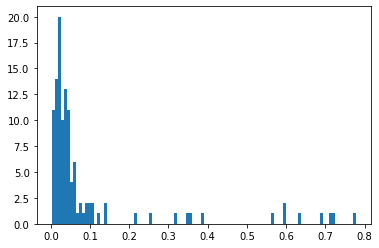

In [12]:
import numpy as np
import matplotlib.pyplot as plt
bi_scores = list()
for word1 in bigram_count.keys():
    for word2, prob in bigram_count[word1].items():
        bi_scores.append(prob)
# bi_scores = np.array(list(bigram_count.values()))
plt.hist(bi_scores, bins=100)
plt.show()

In [13]:
# new_lex = dict()
# for idx, (word, phone) in enumerate(lex.items()):
#     if idx > 4:
#         break
#     new_lex[word] = phone

# print(new_lex)

# from collections import defaultdict
# bigram_count = defaultdict(lambda:defaultdict(int))

# bigram_count_all = 0
# for file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):
#     transcript = read_transcription(file)
#     tmp_words = transcript.split()
#     tmp = [word not in list(new_lex.keys()) for word in tmp_words]
#     if sum(tmp) > 0:
#         continue
#     tmp_words = ["eps"] + tmp_words + ["eps"]
#     bigram_list = list(nltk.bigrams(tmp_words))
#     for bigram in bigram_list:
#         word1, word2 = bigram
#         bigram_count[word1][word2] += 1

# bigram_count = dict(bigram_count)
# for word1 in bigram_count.keys():
#     prob_sum = sum(bigram_count[word1].values())
#     for word2 in bigram_count[word1].keys():
#         bigram_count[word1][word2] /= prob_sum
# print(bigram_count)

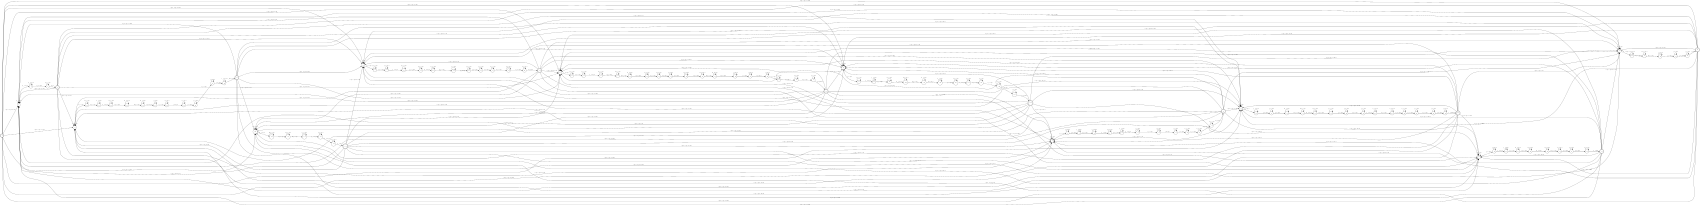

In [14]:
class BigramWfst:
    
    def __init__(self, n=3, lex=lex, self_loop_prob=None, final_prob_dict=None, bi_prob_dict=None):
        """
        Generate a HMM to recognise any single word sequence for words in the lexicon

        Args:
            n (int): states per phone HMM

        Returns:
            the constructed WFST

        """
        
        self.n = n
        self.lex = lex
        self.final_prob_dict = final_prob_dict
        self.self_loop_prob = self_loop_prob
        self.bi_prob_dict = bi_prob_dict
        self.f = self.generate_wfst()
    
    def generate_weighted_phone_wfst(self, f, start_state, phone, n, olabel):
        """
        Generate a weighted WFST representing an n-state left-to-right phone HMM.

        Args:
            f (fst.Fst()): an FST object, assumed to exist already
            start_state (int): the index of the first state, assumed to exist already
            phone (str): the phone label 
            n (int): number of states of the HMM excluding start and end

        Returns:
            the final state of the FST
        """
    

        current_state = start_state

        for i in range(1, n+1):
            if i == n:
                out = olabel
            else:
                out = 0

            in_label = state_table.find('{}_{}'.format(phone, i))

            prev_state = current_state
            current_state = f.add_state()
            if self.self_loop_prob == None:
                f.add_arc(prev_state, fst.Arc(in_label, 0, None, prev_state))
                f.add_arc(prev_state, fst.Arc(in_label, out, None, current_state))
            else:
                f.add_arc(prev_state, fst.Arc(in_label, 0, -math.log(self.self_loop_prob), prev_state))
                f.add_arc(prev_state, fst.Arc(in_label, out, -math.log(1-self.self_loop_prob), current_state))
        
        return current_state
    
    
    def generate_wfst(self):
        """
        """
        
        f = fst.Fst()

        # create a single start state
        start_state = f.add_state() # 0
        f.set_start(start_state)
        word_start_dict = dict()
        word_end_dict = dict()
        
        # =====================Bi-gram wfst====================
        for word, phones in self.lex.items():
            if word not in word_start_dict.keys():
                current_state = f.add_state()
                word_start_dict[word] = current_state
                for idx,phone in enumerate(phones):
                    if idx == len(phones)-1:
                            olabel = word_table.find(word)
                            current_state = self.generate_weighted_phone_wfst(f, current_state, phone, self.n, olabel)
                    else:
                        current_state = self.generate_weighted_phone_wfst(f, current_state, phone, self.n, 0)
                if self.final_prob_dict == None:
                    f.set_final(current_state)
                else:
                    f.set_final(current_state, -math.log(self.final_prob_dict[word]))
                word_end_dict[word] = current_state
            if word in self.bi_prob_dict["eps"].keys():
                current_start_state = word_start_dict[word]
                f.add_arc(start_state, fst.Arc(0, 0, -math.log(self.bi_prob_dict["eps"][word]), current_start_state))
                
            for word2, prob in self.bi_prob_dict[word].items():
                if word2 == "eps":
                    continue
                if word2 not in self.lex.keys():
                    continue
#                 if self.bi_prob_dict[word][word2] < 0.06:
#                     continue
                if word2 not in word_start_dict.keys():
                    current_state = f.add_state()
                    word_start_dict[word2] = current_state
                    phones = self.lex[word2]
                    for idx, phone in enumerate(phones):
                        if idx == len(phones)-1:
                            olabel = word_table.find(word2)
                            current_state = self.generate_weighted_phone_wfst(f, current_state, phone, self.n, olabel)
                        else:
                            current_state = self.generate_weighted_phone_wfst(f, current_state, phone, self.n, 0)
                    if self.final_prob_dict == None:
                        f.set_final(current_state)
                    else:
                        f.set_final(current_state, -math.log(self.final_prob_dict[word]))
                    word_end_dict[word2] = current_state
                f.add_arc(word_end_dict[word], fst.Arc(0, 0, -math.log(self.bi_prob_dict[word][word2]), word_start_dict[word2]))    
        
        f.set_input_symbols(state_table)
        f.set_output_symbols(word_table)
        
        return f

    
    def plot(self):
        """
        """
    
        # We need special code to display the higher-resolution WFSTs inside Jupyter notebook
        from subprocess import check_call
        from IPython.display import Image    
        self.f.draw('tmp.dot', portrait=True)
        check_call(['dot','-Tpng','-Gdpi=200','tmp.dot','-o','tmp.png'])
        return Image(filename='tmp.png')
    
BigramWfst(bi_prob_dict = bigram_count).plot()

In [15]:
# create WFST and decoder
f = BigramWfst(bi_prob_dict=bigram_count).f
decoder = BaselineViterbiDecoder()

# create ASR
asr = ASR(f, decoder, CFG.audio_path, CFG.sample_num, verbose_all = True, verbose_result = True)

# save result in a dataframe
result_df_4_1 = pd.DataFrame(columns=["self-prob", "accuracy","num_arcs",
                                      "num_states","decode_time", "backtrace_time", "forward_cnt"])
tmp = pd.Series([None, asr.accuracy, asr.num_arcs, asr.num_states, 
                     asr.decode_time, asr.backtrace_time, asr.forward_cnt], index=result_df_4_1.columns, name=0)
result_df_4_1 = result_df_4_1.append(tmp)
if CFG.DEBUG == False:
    result_df_4_1.to_csv("task_4_bigram_df.csv",index=False)
result_df_4_1

/group/teaching/asr/labs/recordings/0000.wav
Transcription: of of a peter the piper the pickled
Prediction: the a of a of peter the a of picked a peppers the of picked the
Substiution: 3, Deletion: 0, Insertion: 8, Number of words: 8, Accuracy: 1.375
Forward: 113478

/group/teaching/asr/labs/recordings/0001.wav
Transcription: piper peck peppers peter peter picked pickled peck peter piper
Prediction: the a of a peppers peter peter picked picked pickled peck the peter piper the
Substiution: 2, Deletion: 0, Insertion: 5, Number of words: 10, Accuracy: 0.700
Forward: 214908

====================Result from 2 samples==================
-- Accuracy Info  *All Average Values* -------------------------------------------------------------
| Substiution: 2.500, Deletion: 0.000, Insertion: 6.500, Number of words: 9.000, Accuracy: 1.038   |
----------------------------------------------------------------------------------------------------
-- Speed Info  *All Average Values* -----------------------

,self-prob,accuracy,num_arcs,num_states,decode_time,backtrace_time,forward_cnt
0,NaN,1.0375,316.0,116.0,8.888326,0.002835,164193.0


### 2. Tree structured lexicon

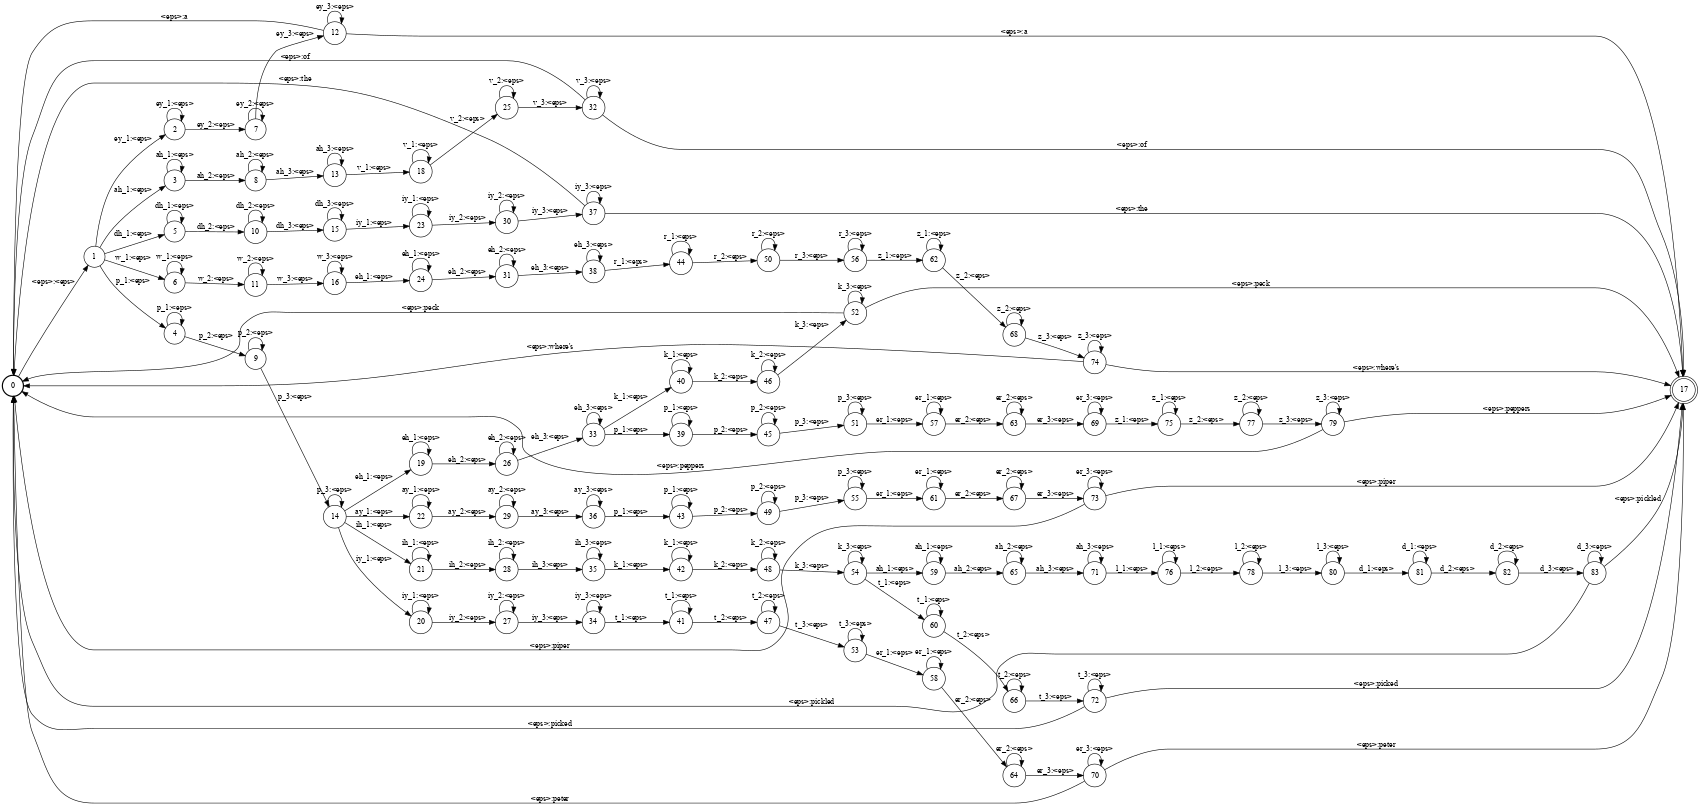

In [16]:
wfst = BaselineWfst()
f = fst.determinize(wfst.f)
wfst.f = f
wfst.plot()

In [17]:
# create WFST and decoder
f = fst.determinize(BaselineWfst().f)
decoder = BaselineViterbiDecoder()

# create ASR
asr = ASR(f, decoder, CFG.audio_path, CFG.sample_num, verbose_all = True, verbose_result = True)

# save result in a dataframe
result_df_4_2 = pd.DataFrame(columns=["self-prob", "accuracy","num_arcs",
                                      "num_states","decode_time", "backtrace_time", "forward_cnt"])
tmp = pd.Series([None, asr.accuracy, asr.num_arcs, asr.num_states, 
                     asr.decode_time, asr.backtrace_time, asr.forward_cnt], index=result_df_4_2.columns, name=0)
result_df_4_2 = result_df_4_2.append(tmp)
if CFG.DEBUG == False:
    result_df_4_2.to_csv("task_4_tree_lex_df.csv",index=False)
result_df_4_2

/group/teaching/asr/labs/recordings/0000.wav
Transcription: of of a peter the piper the pickled
Prediction: the a of a of of peter the a of picked a peppers the the picked the
Substiution: 3, Deletion: 0, Insertion: 9, Number of words: 8, Accuracy: 1.500
Forward: 87299

/group/teaching/asr/labs/recordings/0001.wav
Transcription: piper peck peppers peter peter picked pickled peck peter piper
Prediction: the a the of a peppers peter peter picked picked pickled peck the peter piper the
Substiution: 2, Deletion: 0, Insertion: 6, Number of words: 10, Accuracy: 0.800
Forward: 165545

====================Result from 2 samples==================
-- Accuracy Info  *All Average Values* -------------------------------------------------------------
| Substiution: 2.500, Deletion: 0.000, Insertion: 7.500, Number of words: 9.000, Accuracy: 1.150   |
----------------------------------------------------------------------------------------------------
-- Speed Info  *All Average Values* ----------------

,self-prob,accuracy,num_arcs,num_states,decode_time,backtrace_time,forward_cnt
0,NaN,1.15,183.0,84.0,7.042999,0.001019,126422.0


### 3. Language model look-ahead 

In [202]:
prev_word = 'piper'
f = fst.determinize(BaselineWfst().f)

LM = {prev_word: [0] * f.num_states() for prev_word in bigram_count.keys()}

print(bigram_count.keys())

traverse_states = list(f.states())
done_states = []

for state in f.states():
    if float(f.final(state)) == 0:
        final_state = state
        done_states.append(final_state)
        traverse_states.remove(final_state)
        
for state in traverse_states:
    for arc in f.arcs(state):
        if arc.nextstate == final_state:
            print(state)
            next_word = f.output_symbols().find(arc.olabel)
            for prev_word in LM.keys():
                LM[prev_word][state] = bigram_count[prev_word][next_word]
            traverse_states.remove(state)
            done_states.append(state)
            break
            
print()

while traverse_states:
#     print(traverse_states) 
    for state in traverse_states:
        if all([arc.nextstate in done_states + [state] for arc in f.arcs(state)]):
            print(state)
            for prev_word in LM.keys():
                LM[prev_word][state] = sum(LM[prev_word][arc.nextstate] for arc in f.arcs(state))
            traverse_states.remove(state)
            done_states.append(state)
# print(LM.items())
for word in bigram_count.keys():
    print(LM[word][0])

    
# print(LM[prev_word])




dict_keys(['eps', 'of', 'a', 'peter', 'the', 'piper', 'pickled', 'peck', 'peppers', 'picked', "where's"])
12
32
37
52
70
72
74
79
83

7
25
30
46
64
66
68
77
82
2
18
23
40
58
60
62
75
81
13
15
53
56
69
80
8
10
47
50
63
78
3
5
41
44
57
76
34
38
51
71
27
31
45
65
20
24
39
59
16
33
54
11
26
48
6
19
42
35
28
21


KeyboardInterrupt: 

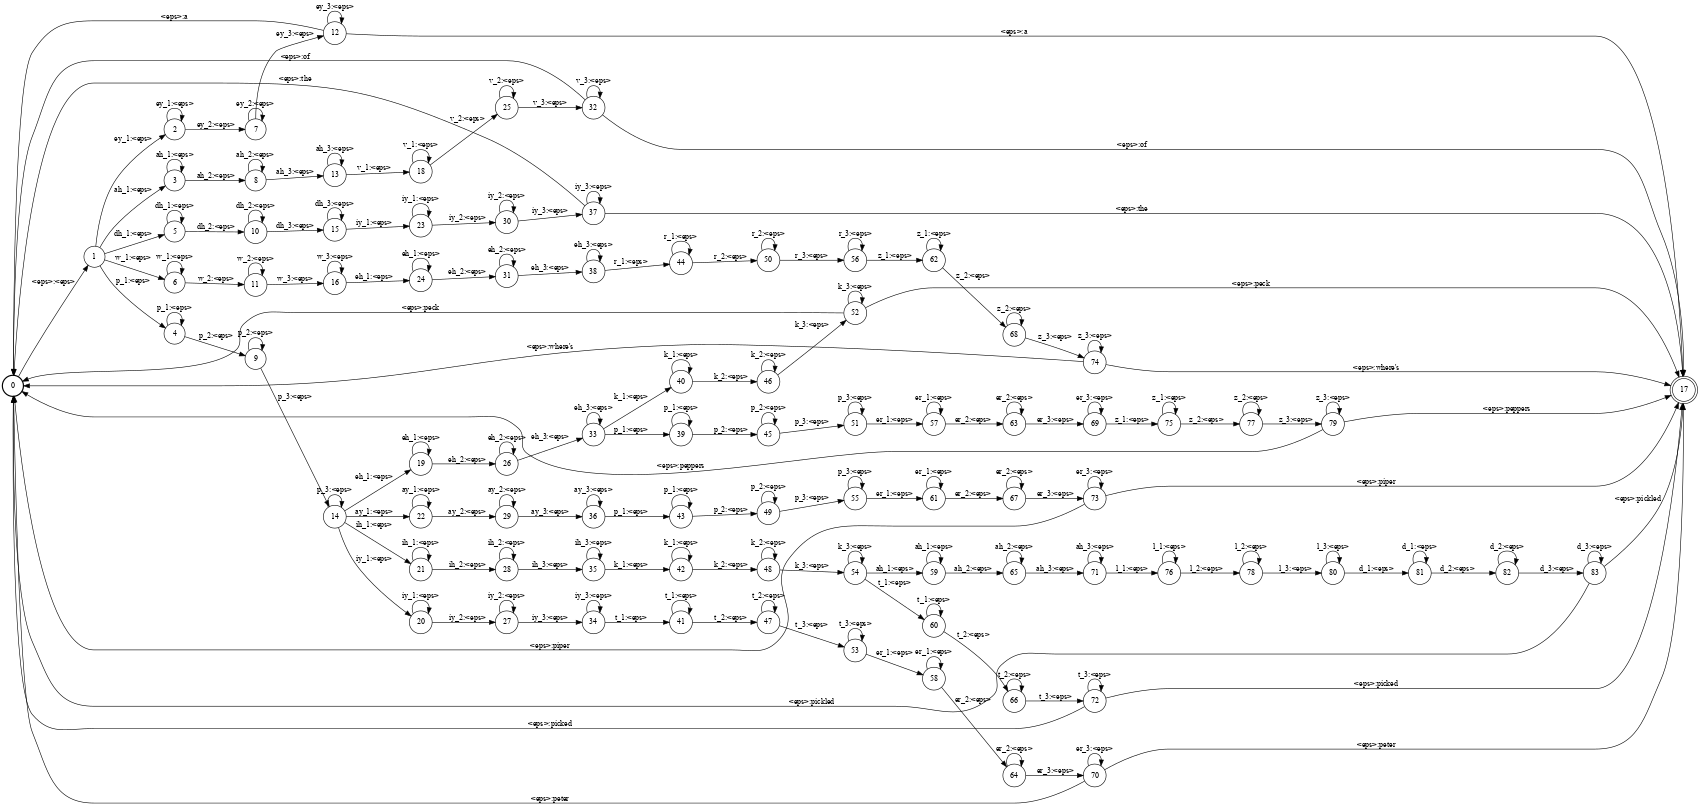

In [156]:
wfst = BaselineWfst()
f = fst.determinize(wfst.f)
wfst.f = f
wfst.plot()

### 3.2 with language model pruning

### 4. Stack decoder (A* search)

In [30]:
class AStarViterbiDecoder:
    
    NLL_ZERO = 1e10  # define a constant representing -log(0).  This is really infinite, but approximate
                     # it here with a very large number
    
    def __init__(self, f = None, audio_file_name = None):
        """Set up the decoder class with an audio file and WFST f
        """
        self.om = observation_model.ObservationModel()
        self.f = f
        self.audio_file_name = audio_file_name
        
        self.forward_cnt = 0

        
    def initialise_decoding(self):
        """set up the values for V_j(0) (as negative log-likelihoods)
        
        """
        # dynamic loading
        if self.audio_file_name:
            self.om.load_audio(self.audio_file_name)
        else:
            self.om.load_dummy_audio()
    
    
    
        self.forward_cnt = 0

        self.end = False
        self.Q = []
        heapq.heapify(self.Q)
    
        self.V = []   # stores likelihood along best path reaching state j
        self.B = []   # stores identity of best previous state reaching state j
        self.W = []   # stores output labels sequence along arc reaching j - this removes need for 
                      # extra code to read the output sequence along the best path
        
        for t in range(self.om.observation_length()+1):
            self.V.append([self.NLL_ZERO]*self.f.num_states())
            self.B.append([-1]*self.f.num_states())
            self.W.append([[] for i in range(self.f.num_states())])  #  multiplying the empty list doesn't make multiple
        
        # The above code means that self.V[t][j] for t = 0, ... T gives the Viterbi cost
        # of state j, time t (in negative log-likelihood form)
        # Initialising the costs to NLL_ZERO effectively means zero probability    
        
        # give the WFST start state a probability of 1.0   (NLL = 0.0)
        self.V[0][self.f.start()] = 0.0
        
        heapq.heappush(self.Q,(self.V[0][self.f.start()],0,self.f.start()))
        self.traverse = [(0,self.f.start())]
             
        
    def traverse_epsilon_arcs(self):
        """
        Traverse arcs with <eps> on the input at time t and state i
        
        These correspond to transitions that don't emit an observation
        
        """
        
        while self.traverse:
            
            # Set i to the ID of the current state, the first 
            # item in the list (and remove it from the list)
            t, i = self.traverse.pop(0)
            # don't bother traversing states which have zero probability
            if self.V[t][i] == self.NLL_ZERO:
                    continue
        
            for arc in self.f.arcs(i):
                
                if arc.ilabel == 0:     # if <eps> transition
                  
                    j = arc.nextstate   # ID of next state  
                
                    if self.V[t][j] > self.V[t][i] + float(arc.weight):
                        
                        # this means we've found a lower-cost path to
                        # state j at time t.  We might need to add it
                        # back to the processing queue.
                        self.V[t][j] = self.V[t][i] + float(arc.weight)
                        
                        # save backtrace information.  In the case of an epsilon transition, 
                        # we save the identity of the best state at t-1.  This means we may not
                        # be able to fully recover the best path, but to do otherwise would
                        # require a more complicated way of storing backtrace information
                        self.B[t][j] = self.B[t][i] 
                        
                        # and save the output labels encountered - this is a list, because
                        # there could be multiple output labels (in the case of <eps> arcs)
                        if arc.olabel != 0:
                            self.W[t][j] = self.W[t][i] + [arc.olabel]
                        else:
                            self.W[t][j] = self.W[t][i]
                        
                        if j not in self.traverse:
                            self.traverse.append((t,j))
                            
                        heapq.heappush(self.Q, (self.V[t][j],t,j))


    
    def forward_step(self, t, i):
                        
        if not self.V[t][i] == self.NLL_ZERO:   # no point in propagating states with zero probability
                        
            for arc in self.f.arcs(i):
                
                if arc.ilabel != 0: # <eps> transitions don't emit an observation
                    j = arc.nextstate
                    tp = float(arc.weight)  # transition prob
                    ep = -self.om.log_observation_probability(self.f.input_symbols().find(arc.ilabel), t+1)  # emission negative log prob
                    prob = tp + ep + self.V[t][i] # they're logs

                    self.forward_cnt += 1
                    
                    if prob < self.V[t+1][j]:
                        self.V[t+1][j] = prob
                        self.B[t+1][j] = i
    
                        # store the output labels encountered too
                        if arc.olabel !=0:
                            self.W[t+1][j] = [arc.olabel]
                        else:
                            self.W[t+1][j] = []
                                                
                        heapq.heappush(self.Q, (self.V[t+1][j],t+1,j))
                        self.traverse.append((t+1,j))

    
    def finalise_decoding(self):
        """ this incorporates the probability of terminating at each state
        """
        
        for state in self.f.states():
            final_weight = float(self.f.final(state))
            if self.V[-1][state] != self.NLL_ZERO:
                if final_weight == math.inf:
                    self.V[-1][state] = self.NLL_ZERO  # effectively says that we can't end in this state
                else:
                    self.V[-1][state] += final_weight          
        # get a list of all states where there was a path ending with non-zero probability
        finished = [x for x in self.V[-1] if x < self.NLL_ZERO]
        if not finished:  # if empty
            print("No path got to the end of the observations.")
            
            return False
            
            
        print(self.V[-1])
        
        return True
        
    def decode(self):
        
        self.initialise_decoding()
        while True:
            (v,t,i) = heapq.heappop(self.Q)
#             print(v,t,i)
            if t == self.om.observation_length() and self.finalise_decoding():
                print(v,t,i)
                print('break')
                break
            self.forward_step(t,i)
            self.traverse_epsilon_arcs()
        print('forward_cnt')
        print(self.forward_cnt)
    
    def backtrace(self):
        
        best_final_state = self.V[-1].index(min(self.V[-1])) # argmin
        best_state_sequence = [best_final_state]
        best_out_sequence = []
        
        t = self.om.observation_length()   # ie T
        j = best_final_state
        
        while t >= 0:
            i = self.B[t][j]
            best_state_sequence.append(i)
            best_out_sequence = self.W[t][j] + best_out_sequence  # computer scientists might like
                                                                                # to make this more efficient!

            # continue the backtrace at state i, time t-1
            j = i  
            t-=1
            
        best_state_sequence.reverse()
        
        # convert the best output sequence from FST integer labels into strings
        best_out_sequence = ' '.join([self.f.output_symbols().find(label) for label in best_out_sequence])
        
        return (best_state_sequence, best_out_sequence)





In [31]:
# create WFST and decoder
f = BaselineWfst().f
decoder = AStarViterbiDecoder()

# create ASR
asr = ASR(f, decoder, CFG.audio_path, CFG.sample_num, verbose_all = True, verbose_result = True)

# save result in a dataframe
result_df_3_2 = pd.DataFrame(columns=["self-prob", "accuracy","num_arcs",
                                      "num_states","decode_time", "backtrace_time", "forward_cnt"])
tmp = pd.Series([None, asr.accuracy, asr.num_arcs, asr.num_states, 
                     asr.decode_time, asr.backtrace_time, asr.forward_cnt], index=result_df_3_2.columns, name=0)
result_df_3_2 = result_df_3_2.append(tmp)
if CFG.DEBUG == False:
    result_df_3_2.to_csv("task_3_A*_search_df.csv",index=False)
result_df_3_2

No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
[10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 100

,self-prob,accuracy,num_arcs,num_states,decode_time,backtrace_time,forward_cnt
0,NaN,1.15,230.0,116.0,8.981268,0.00139,172728.0
